In [1]:
import logging, sys
LOG_LEVEL = logging.DEBUG
logging.basicConfig(filename='current.log',encoding='utf-8',level=LOG_LEVEL, filemode = 'w', format='%(asctime)s-%(levelname)s: Process %(process)d said: %(message)s')
log = logging.getLogger()
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
import tensorflow as tf
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

## Check if Tensorflow really runs on your GPU
# refer first to the README (!), then to this article, especially if you are using a windows machine https://www.tensorflow.org/install/pip#windows-wsl2_1
#tf_config = tf.config.list_physical_devices('GPU')
#logging.debug("Num GPUs Available: {}".format(len(tf.config.list_physical_devices('GPU'))))
#logging.debug(tf_config)
    
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     #tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#     logging.debug(tf.config.experimental.set_memory_growth(gpus[0], True))
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     logging.debug((len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs"))
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     logging.debug(e)


2024-04-10 01:01:16.963926: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


2024-04-10 01:01:18.833538: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-10 01:01:18.834831: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-04-10 01:01:18.878954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 44.53GiB deviceMemoryBandwidth: 804.75GiB/s
2024-04-10 01:01:18.879504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 44.53GiB deviceMemoryBandwidth: 804.75GiB/s
2024-04-10 01:01:18.880010: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:63:00.0 name: NVIDIA L40S computeC

In [3]:
#HACK fix import and order
from skimage import exposure, io
from flowdec import data as tfd_data
from flowdec import psf as tfd_psf
from flowdec import restoration as tfd_restoration
from skimage.transform import rescale
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
from pprint import pprint

from FOV import FOV

%matplotlib inline

matplotlib data path: /fs/home/jbrenner/.conda/envs/tf_conda/lib/python3.9/site-packages/matplotlib/mpl-data
CONFIGDIR=/fs/home/jbrenner/.config/matplotlib
interactive is False
platform is linux
CONFIGDIR=/fs/home/jbrenner/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/fs/home/jbrenner/.cache/matplotlib
Using fontManager instance from /fs/home/jbrenner/.cache/matplotlib/fontlist-v330.json
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [4]:
# Microscope Parameters from the Arctis 100x iFLM
# Image properties
# Size of the PSF array, pixels
size_x = 256
size_y = 256
size_z = 128
#
# # Microscope parameters
NA          = 0.9
wavelength  = 0.588 # microns
M           = 100   # magnification
ns          = 1.0  # specimen refractive index (RI)
ng0         = 1.0   # coverslip RI design value
ni0         = 1.0   # immersion medium RI design value
ti0         = 3000   # microns, working distance (immersion medium thickness) design value
tg0         = 0   # microns, coverslip thickness design value
res_lateral = 0.075   # microns
res_axial   = 0.25  # microns

# ng          = 1.5   # coverslip RI experimental value (defaults to ng0 if not given)
# ni          = 1.5   # immersion medium RI experimental value (defaults to ni0 if not given)
# tg          = 170   # microns, coverslip thickness experimental value (defaults to tg0 if not given)
# pZ          = 2     # microns, particle distance from coverslip
#
# # Precision control
# num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
# num_samples  = 1000 # Number of pupil samples along radial direction
# oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

In [5]:
# Set directory of image stack
# sudo mount -t drvfs '//samba-pool-pool-plitzko3.biochem.mpg.de/pool-plitzko3' /mnt/plitzko3
file_pattern = '/fs/pool/pool-plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/RAGE_01.lif'
output_folder = '/fs/pool/pool-plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/'
LIFFILE = True
logging.debug("Current File: {}".format(file_pattern))

Current File: /fs/pool/pool-plitzko3/Johann/03-Data/04-LightMicroscopy/EMBO_course_decon_testing/RAGE_01.lif


In [6]:
# Import LIF data with a custom written handler class here
# FIXME Comment class properly
#HACK Loop over all FOVs
#HACK handle exceptions in class
#TODO calibrate images
#TODO in the very future optimize import, this takes ages!!!
#TODO map to overview


if LIFFILE:
    test_fov = FOV(file_pattern,2)
    logging.debug(test_fov.print())

In [ ]:
#HACK loop over channels
if LIFFILE:
    test_stack = test_fov.get_channel_stack(channel_num=1)
    logging.debug(test_stack.shape)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Image'

In [ ]:
if LIFFILE:
    num = test_stack.shape[0]
    fig,ax = plt.subplots(1,num, figsize=(15,5))
    for chan in range(num):
        if num == 1:
            ax.imshow(np.max(test_stack[chan],axis=0))
            ax.axis('off')
        else:
            ax[chan].imshow(np.max(test_stack[chan],axis=0))
            ax[chan].axis('off')

In [ ]:
# Load image stack for debugging
if  not LIFFILE:
    stack = io.imread('input.tif', plugin="tifffile").astype(np.float16)
else:
    stack = test_stack[0].astype(np.float16)
logging.debug(stack.shape)
logging.debug(stack.dtype)

FileNotFoundError: [Errno 2] No such file or directory: '/fs/gpfs41/lv01/fileset02/pool/pool-plitzko3/Johann/04-Programs/3D-correlation-deconvonvolution/input.tif'

In [ ]:
print(np.max(stack))

255.0


In [ ]:
scalexy, scalez = 1, 1
if np.max(scalexy) == 1 and np.max(scalez) == 1:
    stack_scaled = stack
else:
    stack_scaled = rescale(stack, (scalez,scalexy,scalexy), mode='constant', order=2, anti_aliasing=True) 
logging.debug(stack_scaled.shape)

(39, 1024, 1024)


In [ ]:
# This is meant to be representative of the arctis 100x widefield image capture (all distance units are in microns)
'''
psf = np.zeros_like(stack_scaled)
psf = tfd_psf.GibsonLanni(
    na=NA,           # Numerical aperture
    m=M,             # Magnification
    ni0=ni0,         # Immersion RI
    res_lateral=res_lateral, # X/Y resolution
    res_axial=res_axial,     # Axial resolution
    wavelength=wavelength,  # Emission wavelength 
    size_x=np.max((size_x, int(stack_scaled.shape[2]))), 
    size_y=np.max((size_y, int(stack_scaled.shape[1]))), 
    size_z=np.min((size_z, int(stack_scaled.shape[0]))),
    ns = ns,
    ng0 = ng0,
    ti0 = ti0,
    tg0 = tg0,
).generate()
logging.debug((psf.shape, psf.dtype))
'''

'\npsf = np.zeros_like(stack_scaled)\npsf = tfd_psf.GibsonLanni(\n    na=NA,           # Numerical aperture\n    m=M,             # Magnification\n    ni0=ni0,         # Immersion RI\n    res_lateral=res_lateral, # X/Y resolution\n    res_axial=res_axial,     # Axial resolution\n    wavelength=wavelength,  # Emission wavelength \n    size_x=np.max((size_x, int(stack_scaled.shape[2]))), \n    size_y=np.max((size_y, int(stack_scaled.shape[1]))), \n    size_z=np.min((size_z, int(stack_scaled.shape[0]))),\n    ns = ns,\n    ng0 = ng0,\n    ti0 = ti0,\n    tg0 = tg0,\n).generate()\nlogging.debug((psf.shape, psf.dtype))\n'

In [ ]:
# This is meant to be representative of the arctis 100x widefield image capture (all distance units are in microns)
psf = np.zeros_like(stack_scaled)
psf = tfd_psf.GibsonLanni(
    na=0.9,           # Numerical aperture
    m=55,             # Magnification
    ni0=ni0,         # Immersion RI
    res_lateral=0.085, # X/Y resolution
    res_axial=0.3,     # Axial resolution
    wavelength=0.58,  # Emission wavelength 
    size_x=np.max((size_x, int(stack_scaled.shape[2]))), 
    size_y=np.max((size_y, int(stack_scaled.shape[1]))), 
    size_z=np.min((size_z, int(stack_scaled.shape[0]))),
    ns          = 1,                                     # specimen refractive index (RI)
    ng0         = 1,                                     # Refractive index of coverslip
    ti0         =  280,     # microns, working distance (immersion medium thickness) design value
    tg0 = tg0,
).generate()
logging.debug((psf.shape, psf.dtype))

((39, 1024, 1024), dtype('float64'))


In [ ]:
# This is meant to be representative of the Leica SP8 50x widefield image capture (all distance units are in microns)
'''
psf = np.zeros_like(stack_scaled)
psf = tfd_psf.GibsonLanni(
    na          = test_fov.NA,                           # Numerical aperture
    m           = test_fov.mag,                          # Magnification
    ni0         = ni0,                                   # Immersion RI
    res_lateral = test_fov.resolution[test_fov.resolution['dimension_name'] == 'x']['resolution_nm'].values[0]  * 1000, # X/Y resolution
    res_axial   = test_fov.resolution[test_fov.resolution['dimension_name'] == 'z']['resolution_nm'].values[0]  * 1000, # Axial resolution
    wavelength  = test_fov.channels[0]['center_wavelength'],  # Emission wavelength 
    size_x      = np.max((size_x, int(stack_scaled.shape[2]))), 
    size_y      = np.max((size_y, int(stack_scaled.shape[1]))), 
    size_z      = np.min((size_z, int(stack_scaled.shape[0]))),
    ns          = 1,                                     # specimen refractive index (RI)
    ng0         = 1,                                     # Refractive index of coverslip
    ti0         = test_fov.working_distance_mm*1000,     # microns, working distance (immersion medium thickness) design value
    tg0         = 0,                                     # microns, coverslip thickness design value
).generate().astype(np.float16)
logging.debug((psf.shape, psf.dtype))
'''

"\npsf = np.zeros_like(stack_scaled)\npsf = tfd_psf.GibsonLanni(\n    na          = test_fov.NA,                           # Numerical aperture\n    m           = test_fov.mag,                          # Magnification\n    ni0         = ni0,                                   # Immersion RI\n    res_lateral = test_fov.resolution[test_fov.resolution['dimension_name'] == 'x']['resolution_nm'].values[0]  * 1000, # X/Y resolution\n    res_axial   = test_fov.resolution[test_fov.resolution['dimension_name'] == 'z']['resolution_nm'].values[0]  * 1000, # Axial resolution\n    wavelength  = test_fov.channels[0]['center_wavelength'],  # Emission wavelength \n    size_x      = np.max((size_x, int(stack_scaled.shape[2]))), \n    size_y      = np.max((size_y, int(stack_scaled.shape[1]))), \n    size_z      = np.min((size_z, int(stack_scaled.shape[0]))),\n    ns          = 1,                                     # specimen refractive index (RI)\n    ng0         = 1,                                    

In [ ]:
# In case your GPU setup allows for a continuous oberserver or saving of intermediate steps (requires more memory, and is not used here)
imgs = []
scores = {}
def observer(img, i, *args):
    imgs.append(img)
    scores[i] = {
    'mse': mean_squared_error(stack_scaled, img),
    #'ssim': structural_similarity(stack_scaled, img, data_range=1), #@TODO find out why SSIM doesn't work as expected
    'psnr': peak_signal_noise_ratio(stack_scaled, img)
    }
    
    if i % 5 == 0:
        if i == 5:
            logging.debug('Observing iteration = {} (dtype = {}, max = {:.3f})'.format(i, img.dtype, img.max()))        
        else:            
            #logging.info('Observing iteration = {} (MSE = {:.2f},SSIM = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['ssim'],scores[i]['psnr']))        
            logging.debug('Observing iteration = {} (MSE = {:.2f}, PSNR = {:.2f})'.format(i, scores[i]['mse'],scores[i]['psnr']))        


acq = tfd_data.Acquisition(stack_scaled,psf)
logging.debug(acq.shape())

{'data': (39, 1024, 1024), 'kernel': (39, 1024, 1024), 'actual': None}


In [ ]:
# Run the deconvolution process and note that deconvolution initialization is best kept separate from 
# execution since the "initialize" operation corresponds to creating a TensorFlow graph, which is a 
# relatively expensive operation and should not be repeated across multiple executions
#algo = fd_restoration.RichardsonLucyDeconvolver(data.ndim, observer_fn=observer).initialize()
#res = algo.run(fd_data.Acquisition(data=data, kernel=psf), niter=30).data
channels = 0
niter = 20
algo = tfd_restoration.RichardsonLucyDeconvolver(n_dims=3,pad_mode='none').initialize()#, observer_fn=observer,
res = algo.run(acq, niter=niter)
logging.debug("Finished successfully!")

2024-04-09 20:30:23.008432: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Finished successfully!


In [ ]:
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(30, 15)
center = tuple([slice(None), slice(10, -10), slice(10, -10)])
titles = ['Original Image', 'Deconvolved Image']
for i, d in enumerate([stack_scaled, res.data ]):#res.data
    img = exposure.adjust_gamma(d[center].max(axis=0), gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/home/johann/anaconda3/envs/tf3.10/lib/python3.10/site-packages/matplotlib/mp

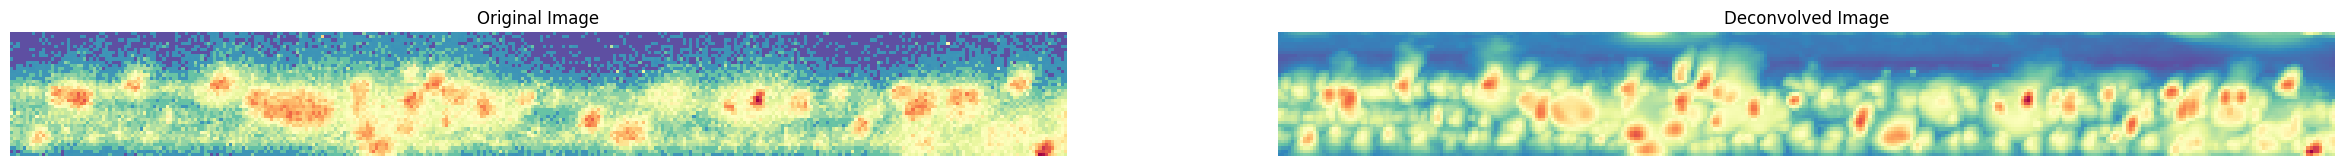

In [ ]:
fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(30, 30)
xz_projection_data = np.max(stack_scaled, axis=1)
xz_projection_decon = np.max(res.data, axis=1)
titles = ['Original Image', 'Deconvolved Image']
for i, d in enumerate([xz_projection_data[:,333:666], xz_projection_decon[:,333:666] ]):#res.data
    img = exposure.adjust_gamma(d,gamma=.2)
    axs[i].imshow(img, cmap='Spectral_r')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

In [ ]:
# Function to plot a selectable image from the stack

def plot_image(i):
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
    ax1.imshow(exposure.adjust_gamma(stack_scaled[i, slice(10, -10), slice(10, -10)]), cmap='Spectral_r')#)'gray'
    ax2.imshow(exposure.adjust_gamma(res.data[i, slice(10, -10), slice(10, -10)]), cmap='Spectral_r')#'Spectral_r')'gray'
    ax2.axis('off')
    fig.show()

# Create a slider widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=res.data.shape[0] - 1,
    step=1,
    description='Image Index:',
    continuous_update=True
)

widgets.interactive(plot_image, i=slider) # Create an interactive widget

interactive(children=(IntSlider(value=0, description='Image Index:', max=38), Output()), _dom_classes=('widget…

handle_msg[830eab16f65845b98c4b7b1bcfa35634]({'header': {'date': datetime.datetime(2024, 4, 9, 18, 30, 50, 828000, tzinfo=tzutc()), 'msg_id': 'e542fb61-b4bb-4202-8dec-345800bb7bb3', 'msg_type': 'comm_msg', 'session': '358c1d23-7356-4931-9d8b-cee0035fcee1', 'username': '82d8545b-6c14-4b94-b383-2ac9b7c67a84', 'version': '5.2'}, 'msg_id': 'e542fb61-b4bb-4202-8dec-345800bb7bb3', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '830eab16f65845b98c4b7b1bcfa35634', 'data': {'method': 'update', 'state': {'outputs': [{'name': 'stderr', 'text': '/tmp/ipykernel_2755/548820959.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown\n  fig.show()\n', 'output_type': 'stream'}, {'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x1000 with 2 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAABk4AAALxCAYAAAAaHFrXAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQGoP

handle_msg[830eab16f65845b98c4b7b1bcfa35634]({'header': {'date': datetime.datetime(2024, 4, 9, 18, 32, 56, 922000, tzinfo=tzutc()), 'msg_id': 'e1a05899-a6c4-47f9-a9cc-dfef5d546797', 'msg_type': 'comm_msg', 'session': '358c1d23-7356-4931-9d8b-cee0035fcee1', 'username': '82d8545b-6c14-4b94-b383-2ac9b7c67a84', 'version': '5.2'}, 'msg_id': 'e1a05899-a6c4-47f9-a9cc-dfef5d546797', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '830eab16f65845b98c4b7b1bcfa35634', 'data': {'method': 'update', 'state': {'outputs': [{'name': 'stderr', 'text': '/tmp/ipykernel_2755/548820959.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown\n  fig.show()\n', 'output_type': 'stream'}]}, 'buffer_paths': []}}, 'buffers': []})
handle_msg[f2ed604c467b47719d0c7c850d603543]({'header': {'date': datetime.datetime(2024, 4, 9, 18, 32, 57, 170000, tzinfo=tzutc()), 'msg_id': '0e6b0e48-8f06-4070-a82f-012fb7f02ece', 'msg_type': 'comm_msg', 'session': '358c1d23-73

handle_msg[830eab16f65845b98c4b7b1bcfa35634]({'header': {'date': datetime.datetime(2024, 4, 9, 18, 32, 57, 195000, tzinfo=tzutc()), 'msg_id': 'e1db5040-d73d-458d-b104-b50ffafb2684', 'msg_type': 'comm_msg', 'session': '358c1d23-7356-4931-9d8b-cee0035fcee1', 'username': '82d8545b-6c14-4b94-b383-2ac9b7c67a84', 'version': '5.2'}, 'msg_id': 'e1db5040-d73d-458d-b104-b50ffafb2684', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '830eab16f65845b98c4b7b1bcfa35634', 'data': {'method': 'update', 'state': {'outputs': [{'name': 'stderr', 'text': '/tmp/ipykernel_2755/548820959.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown\n  fig.show()\n', 'output_type': 'stream'}, {'output_type': 'display_data', 'data': {'text/plain': '<Figure size 2000x1000 with 2 Axes>', 'image/png': 'iVBORw0KGgoAAAANSUhEUgAABk4AAALxCAYAAAAaHFrXAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/H5lhTAAAACXBIWXMAAA9hAAAPYQGoP

In [ ]:
if LIFFILE:
    from datetime import datetime    
    io.imsave(output_folder + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_deconv.tif',res.data)
    io.imsave(output_folder + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_input.tif',stack_scaled)

    io.imsave(output_folder + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_MIP_deconv.tif',np.max(res.data,axis=0))
    io.imsave(output_folder + datetime.today().strftime("%Y-%m-%d_%H-%M-%S") +'_MIP_input.tif',np.max(stack_scaled,axis=0))
